### Imports

In [15]:
from pydantic import BaseModel, Field

from qdrant_client import QdrantClient
from qdrant_client.models import Prefetch, Filter, FieldCondition, MatchText, FusionQuery, Document


from langsmith import traceable, get_current_run_tree

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.types import Send, Command

from langchain_core.messages import AIMessage, ToolMessage

from jinja2 import Template
from typing import Literal, Dict, Any, Annotated, List, Optional, Sequence
from IPython.display import Image, display
from operator import add
from openai import OpenAI

import openai

import random
import ast
import inspect
import instructor
import json

from utils.utils import get_tool_descriptions, format_ai_message

In [16]:
qdrant_client = QdrantClient(url="http://localhost:6333")

In [17]:
def get_embedding(text, model="text-embedding-3-small"):
    response = openai.embeddings.create(
        input=[text],
        model=model,
    )
    return response.data[0].embedding

In [18]:
def retrieve_data(query, qdrant_client, k=5):

    query_embedding = get_embedding(query)

    results = qdrant_client.query_points(
        collection_name="Amazon-items-collection-hybrid-search",
        prefetch=[
            Prefetch(
                query=query_embedding,
                using="text-embedding-3-small",
                limit=20
            ),
            Prefetch(
                query=Document(
                    text=query,
                    model="qdrant/bm25"
                ),
                using="bm25",
                limit=20
            )
        ],
        query=FusionQuery(fusion="rrf"),
        limit=k,
    )

    retrieved_context_ids = []
    retrieved_context = []
    retrieved_context_ratings = []
    similarity_scores = []

    for result in results.points:
        retrieved_context_ids.append(result.payload["parent_asin"])
        retrieved_context.append(result.payload["description"])
        retrieved_context_ratings.append(result.payload["average_rating"])
        similarity_scores.append(result.score)

    return {
        "retrieved_context_ids": retrieved_context_ids,
        "retrieved_context": retrieved_context,
        "retrieved_context_ratings": retrieved_context_ratings,
        "similarity_scores": similarity_scores,
    }

In [19]:
query = "Can I get some speakers?"
answer = retrieve_data(query, qdrant_client, k=10)
answer

{'retrieved_context_ids': ['B0BS15TRJ3',
  'B09Y39SFFL',
  'B0BP1YXF3R',
  'B09TDJBZ7X',
  'B0BNVKS9WH',
  'B0C69MM2TP',
  'B0BG55JZ1T',
  'B0BVZ47N6N',
  'B0B6P9SM9S',
  'B0BVZP14HM'],
 'retrieved_context': ['LENRUE Bluetooth Speakers, Waterproof Portable Speakers with TWS, 24 Playtime, Stereo Sound, Wireless for Home Shower Pool Beach Outdoor ✅ ♫Loud and Crisp Sound - Upgrade 2 high quality horns, plays very clear and it can get very loud. Wthout any distortion and noise.✅ ♫IPX6 Waterproof - Portable bluetooth speakers updates IPX6 waterproof and dustproof, portable for shower, pool, beach. The speaker cannot be completely immersed in water.✅ ♫Portable & Hanging - Equipped with a detachable lanyard, the portable speaker can be hung on bicycles, motorcycles, backpacks, and tents. The speaker is an ideal gift.✅ ♫Wireless Stereo Pairing - Bluetooth speakers perform powerful surround sound by connecting 2 speakers together.✅ ♫ Multi Play Way - Wireless speakers adopt seamless Bluetooth 5

In [20]:
query = "Can I get a tablet for my kid, a watch for me and a laptop for my wife?"
answer = retrieve_data(query, qdrant_client, k=10)
answer

{'retrieved_context_ids': ['B0BRXZDBXZ',
  'B0BL2CZSHT',
  'B0C3XYD574',
  'B0B8NVNQKX',
  'B0CFFGT7RM',
  'B0C142QS8X',
  'B0BFGXRMJN',
  'B0C772GZRF',
  'B09T7B55W3',
  'B0BN7WWH63'],
 'retrieved_context': ["Kids Tablet, 7 inch Tablet for Kids 3GB RAM 32GB ROM, Android 11 Toddler Tablet with WiFi, Bluetooth, GMS, Parental Control, Shockproof Case, Google Play, YouTube, Netflix 【iWawa APP with parental control】This kids tablet has passed the GMS certification and is pre-installed with the iwawa app, specially designed for children. It has password control, remote video control, one-button lock screen and Learning, art, smart games. New-upgrade kids online school, fun interaction, video playback【Android 11.0 & 128 GB Expand】Android 11.0 operating system, 3GB RAM 32GB ROM, support WiFi, Bluetooth, GPS, etc. The HD 1024*600IPS display can offer a perfect experience, You can expand the storage to 128 GB of SD cards for storing photos, music and videos. The upgraded battery can last more t

#### Such complex queries are not easily perceived by llm, need to be expanded and decomposed so llm returns data for all aspects of query.

In [21]:
class QueryExpandResponse(BaseModel):
   statements: List[str]

In [22]:
def query_expand_node(query) -> dict:

   prompt_template =  """You are part of a shopping assistant that can answer questions about products in stock.

    Instructions:
    - You will be given a question and you need to expand it into a list of statements that can be used in contextual search to retrieve relevant products.
    - The statements should not overlap in context.
    - You must return a list of statements.
    - You must read the entire question before returning the statements.

    <Question>
    {{ query }}
    </Question>
    """

   template = Template(prompt_template)
   
   prompt = template.render(
      query=query
   )

   client = instructor.from_openai(OpenAI())

   response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        response_model=QueryExpandResponse,
        messages=[{"role": "system", "content": prompt}],
        temperature=0.5,
   )

   return {
      "queries": response.statements
   }

In [23]:
answer = query_expand_node(query)
answer

{'queries': ['tablet suitable for kids',
  'watch for adults',
  'laptop for wife']}

### Langgraph implementation
#### Query -> Expand -> run throught llm -> aggregate

#### Query expansion - sequential execution


In [24]:
class State(BaseModel):
    expanded_query: List[str] = []
    retrieved_context: Annotated[List[str], add] = []
    initial_query: str = ""
    answer: str = ""


#### Query Expansion / Rewriting Node

In [25]:
class QueryExpandResponse(BaseModel):
    expanded_query: List[str]


In [26]:
@traceable(
    name="agent_node",
    run_type="llm",
    metadata={"ls_provider": "openai", "ls_model_name": "gpt-4.1-mini"}
)
def query_expand_node(state: State):

   prompt_template =  """You are part of a shopping assistant that can answer questions about products in stock.

   Instructions:
      - You will be given a question and you need to expand it into a list of statements that can be used in contextual search to retrieve relevant products.
      - The statements should not overlap in context.
      - You must return a list of statements.
      - You must read the entire question before returning the statements.

      <Question>
      {{ query }}
      </Question>
   """

   template = Template(prompt_template)
   
   prompt = template.render(
      query=state.initial_query
   )

   client = instructor.from_openai(OpenAI())

   response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        response_model=QueryExpandResponse,
        messages=[{"role": "system", "content": prompt}],
        temperature=0.5,
   )

   return {
      "expanded_query": response.expanded_query
      }

#### Retreiver node

In [27]:
@traceable(
    name="embed_query",
    run_type="embedding",
    metadata={"ls_provider": "openai", "ls_model_name": "text-embedding-3-small"}
)
def get_embedding(text, model="text-embedding-3-small"):
    response = openai.embeddings.create(
        input=[text],
        model=model,
    )

    return response.data[0].embedding

@traceable(
    name="retrieve_top_n",
    run_type="retriever"
)
def retrieve(query, k=10) -> dict:

    qdrant_client = QdrantClient(url="http://localhost:6333")

    query_embedding = get_embedding(query)

    results = qdrant_client.query_points(
        collection_name="Amazon-items-collection-hybrid-search",
        prefetch=[
            Prefetch(
                query=query_embedding,
                using="text-embedding-3-small",
                limit=20
            ),
            Prefetch(
                query=Document(
                    text=query,
                    model="qdrant/bm25"
                ),
                using="bm25",
                limit=20
            )
        ],
        query=FusionQuery(fusion="rrf"),
        limit=k,
    )

    retrieved_context = []
    retrieved_context_ids = [] 
    retrieved_context_ratings = []

    for result in results.points:
        retrieved_context_ids.append(result.payload["parent_asin"])
        retrieved_context.append(result.payload["description"])
        retrieved_context_ratings.append(result.payload["average_rating"])

    formatted_context = ""

    for id, chunk, rating in zip(retrieved_context_ids, retrieved_context, retrieved_context_ratings):
        formatted_context += f"- ID: {id}, rating: {rating}, description: {chunk}\n"

    return formatted_context


#### Retriever node - runs through all expanded queries
@traceable(
    name="retriever_node",
    run_type="retriever"
)
def retrieve_node(state: State) -> dict:

    retrieved_context = []

    for query in state.expanded_query:
        retrieved_context.append(retrieve(query))

    return {
        "retrieved_context": retrieved_context
    }

#### Aggregator node

In [28]:
class AggregatorResponse(BaseModel):
    answer: str = Field(description="Answer to the question.")

In [29]:
@traceable(
    name="agent_node",
    run_type="llm",
    metadata={"ls_provider": "openai", "ls_model_name": "gpt-4.1-mini"}
)
def aggregator_node(state: State) -> dict:

   preprocessed_context = "\n".join(state.retrieved_context)

   prompt_template =  """You are a shopping assistant that can answer questions about the products in stock.

   You will be given a question and a list of context.

   Instructions:
   - You need to answer the question based on the provided context only.
   - Never use word context and refer to it as the available products.
   - The answer to the question should contain detailed information about the product and returned with detailed specification in bullet points.

   Context:
   {{ preprocessed_context }}

   Question:
   {{ question }}
   """

   template = Template(prompt_template)
   
   prompt = template.render(
      preprocessed_context=preprocessed_context,
      question=state.initial_query
   )

   client = instructor.from_openai(OpenAI())

   response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        response_model=AggregatorResponse,
        messages=[{"role": "system", "content": prompt}],
        temperature=0.5,
   )

   return {
      "answer": response.answer
   }


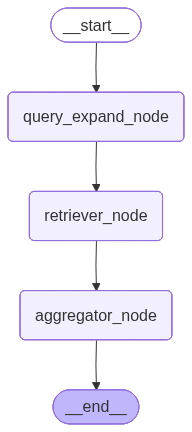

In [31]:
workflow = StateGraph(State)

workflow.add_node("query_expand_node", query_expand_node)

workflow.add_node("retriever_node", retrieve_node)

workflow.add_node("aggregator_node", aggregator_node)

workflow.add_edge(START, "query_expand_node")

workflow.add_edge("query_expand_node", "retriever_node")

workflow.add_edge("retriever_node", "aggregator_node")

workflow.add_edge("aggregator_node", END)

graph = workflow.compile()

display(Image(graph.get_graph().draw_mermaid_png()))


In [32]:
initial_state = {
    "initial_query": "Can I get a tablet for my kid, a watch for me and a laptop for my wife?"
}
result = graph.invoke(initial_state)

In [33]:
result

{'expanded_query': ['tablet for kids', 'watch for adults', 'laptop for wife'],
 'retrieved_context': ['- ID: B0C3XYD574, rating: 4.4, description: ROWT Tablet for Kids 10 inch Kids Tablet 2GB RAM 32GB ROM Android 11 6000mAh Wi-Fi, Bluetooth, Kid-Proof Case(Blue) 【Kids\' Safety & Parental Controls】Looking for a safe tablet that\'s easy for your kids to use? This 10-inch tablet for kids is GMS-certified, has password protection, a content filter, and a one-button lock screen, making it easier for parents to keep an eye on their kids activities and learning.【Creative Educational Content】Our kids tablet provides access to a range of age-appropriate creative kids content such as drawing, educational games, eBooks, learning videos, math tools, and much more! Learning through play is best for kids to understand the world.【Powerful Configuration & Full Access to Google】This Android 11 kids tablet has an HD 1280x800 IPS touchscreen, 1.6 GHz Quad-Core processor, 2GB RAM & 32GB ROM storage, dual 

In [34]:
print(result["answer"])

Yes, you can get all three items from the available products. Here are the details:

1. Tablet for your kid:
- ROWT Tablet for Kids 10 inch
- 2GB RAM, 32GB ROM
- Android 11
- 6000mAh battery
- Wi-Fi, Bluetooth
- Kid-proof case (Blue)
- Features: GMS-certified, parental controls, content filter, one-button lock screen
- HD 1280x800 IPS touchscreen
- 1.6 GHz Quad-Core processor
- Dual cameras
- Large 10.1" screen with eye protection
- Durable protective case with built-in stand

2. Watch for you:
- Blackview R5 Smart Watch
- 24 sports modes
- Heart rate monitor, blood oxygen SpO2
- IP68 waterproof
- Calorie counter
- 1.69" full touch color screen
- Sleep tracking and personalized watch faces
- Long battery life (9-15 days)
- Compatible with iOS 9.0 and Android 4.3+

3. Laptop for your wife:
- Acer Aspire 5 A515-56-347N Slim Laptop
- 15.6" Full HD IPS Display
- 11th Gen Intel i3-1115G4 Dual Core Processor
- 8GB DDR4 RAM
- 128GB NVMe SSD
- WiFi 6, Bluetooth
- Windows 11 Home in S Mode
- Fe

### Query expansion
#### Parallel execution

In [ ]:
class State(BaseModel):
    expanded_query: List[str] = []
    retrieved_context: Annotated[List[str], add] = []
    initial_query: str = ""
    answer: str = ""
    query: str = ""
    k: int = 10

#### Query expansion - rewriting node

In [ ]:
class QueryExpandResponse(BaseModel):
    expanded_query: List[str]

In [ ]:
@traceable(
    name="agent_node",
    run_type="llm",
    metadata={"ls_provider": "openai", "ls_model_name": "gpt-4.1-mini"}
)
def query_expand_node(state: State):

   prompt_template =  """You are part of a shopping assistant that can answer questions about products in stock.

Instructions:
- You will be given a question and you need to expand it into a list statements that can be used in contextual search to retrieve relevant products.
- The statements should not overlap in context. Single item should not be expanded into multiple statements unless it is specifically mentioned in several contexts.

<Question>
{{ query }}
</Question>
"""

   template = Template(prompt_template)
   
   prompt = template.render(
      query=state.initial_query
   )

   client = instructor.from_openai(OpenAI())

   response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        response_model=QueryExpandResponse,
        messages=[{"role": "system", "content": prompt}],
        temperature=0.5,
   )

   return {
      "expanded_query": response.expanded_query
      }

In [ ]:
def query_expand_conditional_edges(state: State):

    send_messages = []

    for query in state.expanded_query:
        # Send - it sends a message to the node, here it is the retrieve_node. Each message has a bound scope of query
        send_messages.append(
            Send(
                "retrieve_node",
                {
                    "query": query,
                    "k": 10
                }
            )
        )

    return send_messages


#### Retreiver node - We dont loop through the context, as Send sends queries with local states to this node individually.

In [ ]:
@traceable(
    name="embed_query",
    run_type="embedding",
    metadata={"ls_provider": "openai", "ls_model_name": "text-embedding-3-small"}
)
def get_embedding(text, model="text-embedding-3-small"):
    response = openai.embeddings.create(
        input=[text],
        model=model,
    )

    return response.data[0].embedding

@traceable(
    name="retrieve_top_n",
    run_type="retriever"
)
def retrieve_node(state: State) -> dict:

    qdrant_client = QdrantClient(url="http://localhost:6333")

    query_embedding = get_embedding(state["query"])

    results = qdrant_client.query_points(
        collection_name="Amazon-items-collection-hybrid-search",
        prefetch=[
            Prefetch(
                query=query_embedding,
                using="text-embedding-3-small",
                limit=20
            ),
            Prefetch(
                query=Document(
                    text=state["query"],
                    model="qdrant/bm25"
                ),
                using="bm25",
                limit=20
            )
        ],
        query=FusionQuery(fusion="rrf"),
        limit=state["k"],
    )

    retrieved_context = []
    retrieved_context_ids = [] 
    retrieved_context_ratings = []

    for result in results.points:
        retrieved_context_ids.append(result.payload["parent_asin"])
        retrieved_context.append(result.payload["description"])
        retrieved_context_ratings.append(result.payload["average_rating"])

    formatted_context = ""

    for id, chunk, rating in zip(retrieved_context_ids, retrieved_context, retrieved_context_ratings):
        formatted_context += f"- ID: {id}, rating: {rating}, description: {chunk}\n"


    # since each retreiver node is returning context separately, 
    # we need to ensure that in State, retrieved_context is a list with add Annotation
    # to avoid overriding the previous context
    return {
        "retrieved_context": [formatted_context],
    }